# Transformers

By Alberto Valdés.

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

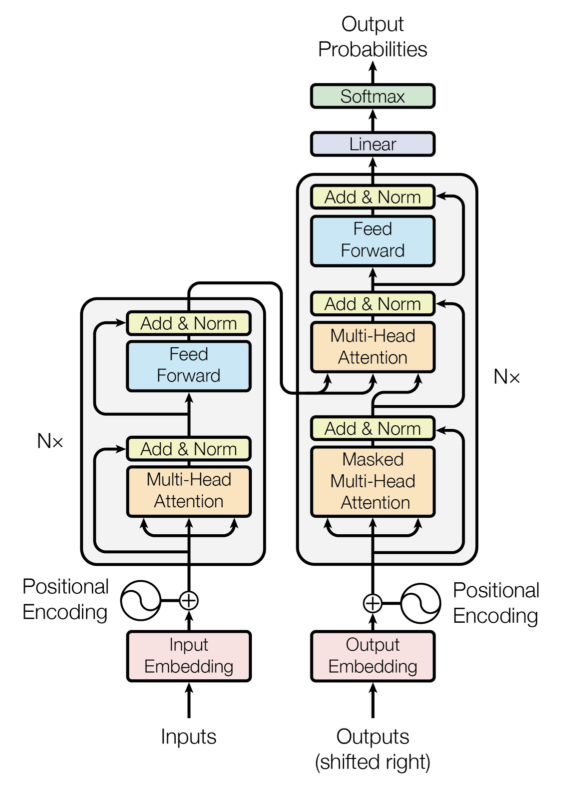

In [4]:
display_img('transformer.png', 10, 10)

A transformer is a deep learning architecture developed by Google and based on the multi-head attention mechanism, proposed in a 2017 paper "Attention Is All You Need".

Text is converted to numerical representations called tokens, and each token is converted into a vector via looking up from a word embedding table. At each layer, each token is then contextualized within the scope of the context window with other (unmasked) tokens via a parallel multi-head attention mechanism allowing the signal for key tokens to be amplified and less important tokens to be diminished.

In [5]:
start = time.time()

### 1. Install Libraries

In [6]:
!pip install -U torchdata
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
!pip install portalocker==2.8.2

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

### 2. Import libraries

In [7]:
import math
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Transformer

from timeit import default_timer as timer

from typing import Iterable, List
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import multi30k, Multi30k
from torchtext.vocab import build_vocab_from_iterator

### 3. Load Dataset

In [8]:
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

### 4. Preprocessing

In [9]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

#### a. Token Transform:

In [10]:
token_transform = {}

In [11]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language = 'de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language = 'en_core_web_sm')

In [12]:
token_transform[TGT_LANGUAGE]('Hi! Mi name is Alberto Valdes')

['Hi', '!', 'Mi', 'name', 'is', 'Alberto', 'Valdes']

#### b. Train iter:



In [13]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [14]:
train_iter = Multi30k(split = 'train', language_pair = (SRC_LANGUAGE, TGT_LANGUAGE))

In [15]:
for data_sample in train_iter:

  break

In [16]:
data_sample

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'Two young, White males are outside near many bushes.')

In [17]:
language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

In [18]:
token_transform[TGT_LANGUAGE](data_sample[language_index[TGT_LANGUAGE]])

['Two',
 'young',
 ',',
 'White',
 'males',
 'are',
 'outside',
 'near',
 'many',
 'bushes',
 '.']

**Now we going to create other function:**

In [19]:
def yield_tokens(data_iter, language):

    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:

        yield token_transform[language](data_sample[language_index[language]])

In [20]:
yield_tokens(train_iter, TGT_LANGUAGE)

<generator object yield_tokens at 0x7f3c5f1d5460>

#### c. Vocab Transform

In [21]:
vocab_transform = {}

In [22]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:

    train_iter = Multi30k(split = 'train', language_pair = (SRC_LANGUAGE, TGT_LANGUAGE))

    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq = 1,
                                                    specials = special_symbols,
                                                    special_first = True)

In [23]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:

  vocab_transform[ln].set_default_index(UNK_IDX)

In [24]:
vocab_transform[TGT_LANGUAGE](['young'])

[25]

In [25]:
vocab_transform[TGT_LANGUAGE](['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'])

[19, 25, 15, 1169, 808, 17, 57, 84, 336, 1339, 5]

#### d. Text Transform

In [26]:
def sequential_transforms(*transforms):

    def func(txt_input):
        for transform in transforms:

            txt_input = transform(txt_input)

        return txt_input

    return func

In [27]:
def tensor_transform(token_ids):

    return torch.cat((torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])))

In [28]:
tensor_transform(vocab_transform[TGT_LANGUAGE](['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']))

tensor([   2,   19,   25,   15, 1169,  808,   17,   57,   84,  336, 1339,    5,
           3])

In [29]:
text_transform = {}

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform)

In [30]:
text_transform[TGT_LANGUAGE]('Two young, White males are outside near many bushes.')

tensor([   2,   19,   25,   15, 1169,  808,   17,   57,   84,  336, 1339,    5,
           3])

In [31]:
def collate_fn(batch):

    src_batch, tgt_batch = [], []

    for src_sample, tgt_sample in batch:

        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value = PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value = PAD_IDX)

    return src_batch, tgt_batch

In [32]:
collate_fn(train_iter)

(tensor([[  2,   2,   2,  ...,   2,   2,   2],
         [ 21,  84,   5,  ...,   5,   5,   3],
         [ 85,  31,  69,  ..., 134,  12,   1],
         ...,
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1]]),
 tensor([[  2,   2,   2,  ...,   2,   2,   2],
         [ 19, 165,   6,  ...,  53,   6,   3],
         [ 25,  36,  61,  ..., 245,  12,   1],
         ...,
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  1,   1,   1,  ...,   1,   1,   1]]))

In [33]:
collate_fn(train_iter)[1].shape

torch.Size([43, 29001])

In [34]:
collate_fn(train_iter)[1][:, 0]

tensor([   2,   19,   25,   15, 1169,  808,   17,   57,   84,  336, 1339,    5,
           3,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1])

### 5. Creation of model

In [35]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
class PositionalEncoding(nn.Module):


    def __init__(self, emb_size, dropout, maxlen = 5000):

        super(PositionalEncoding, self).__init__()

        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)

        pos = torch.arange(0, maxlen).reshape(maxlen, 1)

        pos_embedding = torch.zeros((maxlen, emb_size))

        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)

        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)

        self.register_buffer('pos_embedding', pos_embedding)


    def forward(self, token_embedding):

        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [37]:
class TokenEmbedding(nn.Module):


    def __init__(self, vocab_size, emb_size):

        super(TokenEmbedding, self).__init__()

        self.embedding = nn.Embedding(vocab_size, emb_size)

        self.emb_size = emb_size


    def forward(self, tokens: Tensor):

        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [38]:
class Seq2SeqTransformer(nn.Module):


    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead, src_vocab_size, tgt_vocab_size, dim_feedforward = 512, dropout = 0.1):

        super(Seq2SeqTransformer, self).__init__()

        self.transformer = Transformer(d_model = emb_size, nhead = nhead, num_encoder_layers = num_encoder_layers,
                                       num_decoder_layers = num_decoder_layers, dim_feedforward = dim_feedforward, dropout = dropout)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)

        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)

        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)

        self.positional_encoding = PositionalEncoding(emb_size, dropout = dropout)


    def forward(self, src, trg, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, memory_key_padding_mask):

        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask, memory_key_padding_mask)

        return self.generator(outs)


    def encode(self, src, src_mask):

        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)


    def decode(self, tgt, memory, tgt_mask):

        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)

In [39]:
def generate_square_subsequent_mask(sz):

    mask = (torch.triu(torch.ones((sz, sz), device = DEVICE)) == 1).transpose(0, 1)

    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

    return mask

In [40]:
def create_mask(src, tgt):

    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device = DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

### 6. Set Parameters

In [41]:
torch.manual_seed(0)

In [42]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

In [43]:
SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, EMB_SIZE, NHEAD, FFN_HID_DIM, BATCH_SIZE, NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS

(19214, 10837, 512, 8, 512, 128, 3, 3)

### 7. Load Model

In [44]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

In [45]:
# Initialize weights

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [46]:
transformer = transformer.to(DEVICE)

In [47]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [48]:
optimizer = torch.optim.Adam(transformer.parameters(), lr = 0.0001, betas = (0.9, 0.98), eps = 1e-9)

### 8. Exercises

In [49]:
train_iter = Multi30k(split = 'train', language_pair = (SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size = BATCH_SIZE, collate_fn = collate_fn)

In [50]:
c = 0

for src, tgt in train_dataloader:

  src = src.to(DEVICE)
  tgt = tgt.to(DEVICE)

  c = c + 1

  if c == 2:

    break

In [51]:
src

tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  5, 129,  21,  ...,  88,  21,  84],
        [456,  67,  42,  ...,  35,  76,  76],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:0')

In [52]:
src.shape

torch.Size([46, 128])

In [53]:
tgt.shape

torch.Size([37, 128])

In [54]:
tgt_input = tgt[:-1, :]

In [55]:
tgt_input.shape

torch.Size([36, 128])

In [56]:
src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

In [57]:
src_mask.shape

torch.Size([46, 46])

In [58]:
tgt_mask.shape

torch.Size([36, 36])

In [59]:
src_padding_mask.shape

torch.Size([128, 46])

In [60]:
tgt_padding_mask.shape

torch.Size([128, 36])

In [61]:
logits = transformer(src, tgt_input,
                     src_mask, tgt_mask,
                     src_padding_mask, tgt_padding_mask, src_padding_mask)

In [62]:
tgt_out = tgt[1:, :]

In [63]:
tgt_out.shape

torch.Size([36, 128])

In [64]:
logits.shape

torch.Size([36, 128, 10837])

### 9. Train

In [65]:
def train_epoch(model, optimizer):

    model.train()

    losses = 0

    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:

        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))

In [66]:
def evaluate(model):

    model.eval()

    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:

        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [67]:
NUM_EPOCHS = 17

In [68]:
for epoch in range(1, NUM_EPOCHS+1):

    start_time = timer()

    train_loss = train_epoch(transformer, optimizer)

    end_time = timer()

    val_loss = evaluate(transformer)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 5.343, Val loss: 4.112, Epoch time = 42.881s
Epoch: 2, Train loss: 3.764, Val loss: 3.321, Epoch time = 43.045s
Epoch: 3, Train loss: 3.162, Val loss: 2.895, Epoch time = 43.748s
Epoch: 4, Train loss: 2.771, Val loss: 2.628, Epoch time = 42.890s
Epoch: 5, Train loss: 2.482, Val loss: 2.445, Epoch time = 44.135s
Epoch: 6, Train loss: 2.251, Val loss: 2.306, Epoch time = 45.116s
Epoch: 7, Train loss: 2.057, Val loss: 2.208, Epoch time = 45.837s
Epoch: 8, Train loss: 1.897, Val loss: 2.108, Epoch time = 45.780s
Epoch: 9, Train loss: 1.755, Val loss: 2.053, Epoch time = 44.913s
Epoch: 10, Train loss: 1.631, Val loss: 2.008, Epoch time = 45.124s
Epoch: 11, Train loss: 1.519, Val loss: 1.965, Epoch time = 45.169s
Epoch: 12, Train loss: 1.418, Val loss: 1.941, Epoch time = 45.863s
Epoch: 13, Train loss: 1.335, Val loss: 1.954, Epoch time = 45.800s
Epoch: 14, Train loss: 1.254, Val loss: 1.945, Epoch time = 44.938s
Epoch: 15, Train loss: 1.175, Val loss: 1.929, Epoch time

### 10. Inference

In [69]:
transformer.eval()

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [70]:
src_sentence = "Eine Gruppe von Menschen steht vor einem Iglu ."

In [71]:
text_transform[SRC_LANGUAGE](src_sentence)

tensor([   2,   14,   38,   24,   54,   30,   28,    6, 6132,    4,    3])

In [72]:
src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)

In [73]:
src

tensor([[   2],
        [  14],
        [  38],
        [  24],
        [  54],
        [  30],
        [  28],
        [   6],
        [6132],
        [   4],
        [   3]])

In [74]:
num_tokens = src.shape[0]

In [75]:
num_tokens

11

In [76]:
src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

In [77]:
src_mask.shape

torch.Size([11, 11])

In [78]:
max_len = num_tokens + 5

In [79]:
start_symbol = BOS_IDX

In [80]:
src = src.to(DEVICE)
src_mask = src_mask.to(DEVICE)

In [81]:
memory = transformer.encode(src, src_mask)

In [82]:
ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)

In [83]:
ys.shape

torch.Size([1, 1])

In [84]:
for i in range(max_len - 1):

    memory = memory.to(DEVICE)

    tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)

    out = transformer.decode(ys, memory, tgt_mask)

    out = out.transpose(0, 1)

    prob = transformer.generator(out[:, -1])

    _, next_word = torch.max(prob, dim=1)

    next_word = next_word.item()

    ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)

    if next_word == EOS_IDX:

      break

In [85]:
tgt_tokens = ys

In [86]:
tgt_tokens

tensor([[   2],
        [   6],
        [  39],
        [  13],
        [  22],
        [  37],
        [   7],
        [  44],
        [  13],
        [  28],
        [5506],
        [   5],
        [   3]], device='cuda:0')

In [87]:
tgt_tokens_2 = list(tgt_tokens.cpu().numpy())

In [88]:
tgt_tokens_2

[array([2]),
 array([6]),
 array([39]),
 array([13]),
 array([22]),
 array([37]),
 array([7]),
 array([44]),
 array([13]),
 array([28]),
 array([5506]),
 array([5]),
 array([3])]

In [89]:
tgt_tokens_3 = vocab_transform[TGT_LANGUAGE].lookup_tokens(tgt_tokens_2)

In [90]:
tgt_tokens_3

['<bos>',
 'A',
 'group',
 'of',
 'people',
 'standing',
 'in',
 'front',
 'of',
 'an',
 'igloo',
 '.',
 '<eos>']

In [91]:
tgt_tokens_4 = " ".join(tgt_tokens_3)

In [92]:
tgt_tokens_4

'<bos> A group of people standing in front of an igloo . <eos>'

In [93]:
tgt_tokens_5 = tgt_tokens_4.replace("<bos>", "").replace("<eos>", "")

In [94]:
tgt_tokens_5

' A group of people standing in front of an igloo . '

### Time of execution

In [95]:
end = time.time()

In [96]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 15 minutes and 27 seconds.
